## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures
from src.models.HardSphereGAN import GAN
from src.models.StaticScaler import StaticMinMaxScaler
from src.HSDataset import HSDataset

%cd -

plt.set_cmap("viridis")

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


<Figure size 640x480 with 0 Axes>

# Hard spheres model development


First stage: Develop a CNN - based GAN to work with ordered point clouds.'

This notebook is an attempt at the simpler hexagonal and square lattices after slow progress in the full-scale experiment.

In [11]:

phis = [0.84] # Add more phis here


path = Path("../data/raw/samples") # Full scale data
path = Path("../data/raw/crystal/Hex") # Hex lattice
path = Path("../data/raw/crystal/Sq") # Square lattice

files, dataframe, metadata = load_raw_data(path, phi=phis, subpath="disorder-0.2")
# files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe.sort_index()

Number of Files found :  100


class         x         y    r
experiment   sample                                   
disorder-0.2 sample-1       1 -0.030240  0.007020  0.5
             sample-1       1  1.017802  0.022341  0.5
             sample-1       1  1.867262 -0.067134  0.5
             sample-1       1  2.810836 -0.018990  0.5
             sample-1       1  3.807303  0.056676  0.5
...                       ...       ...       ...  ...
             sample-99      1 -4.885654 -1.052958  0.5
             sample-99      1 -3.872113 -1.066002  0.5
             sample-99      1 -3.000729 -1.056671  0.5
             sample-99      1 -1.996436 -0.901643  0.5
             sample-99      1 -0.939445 -0.890730  0.5

[160000 rows x 4 columns]

In [12]:
# Hex lattice

N = 1600 
X_box = 41.076212368516387
Y_box = 35.573043402379753   
 
# Square lattice
N = 1600
X_box = 38.225722823651111
y_box = 38.225722823651111 
dataframe["r"] = 0.375 # Fixed radius for all data, for square lattice

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StaticMinMaxScaler(
    columns = ["x", "y", "r"],
    maximum = [X_box, Y_box, 2*X_box], # NOTE: Tuned for physical feasibility
    minimum = [-X_box, -Y_box, 0] # NOTE: Tuned for physical feasibility
)

dataframe_scaled = pd.DataFrame(scaler.transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r
# dataframe_scaled = dataframe_scaled.sort_values(by=["experiment", "sample"])
dataframe_scaled.describe().round(7)

,x,y,r
count,160000.000000,160000.000000,160000.000000
mean,0.500041,0.500069,0.004905
std,0.146112,0.157006,0.000000
min,0.247042,0.228179,0.004905
25%,0.373534,0.364100,0.004905
50%,0.500025,0.500002,0.004905
75%,0.626463,0.635903,0.004905
max,0.752958,0.771821,0.004905


## Example

torch.Size([1, 1600, 3])


<Axes: >

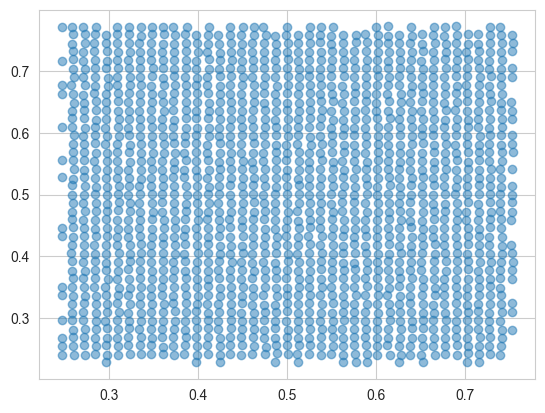

In [17]:
sample = dataframe_scaled.copy().query("(sample=='sample-1')").loc[:,["x", "y", "r"]].reset_index(drop=True)
sample = torch.tensor(sample.values).unsqueeze(0)
print(sample.shape)
plot_pointcloud(sample[0], plot_radius=False)

## Train the model

In [21]:
run_params = {
    "training":{
        "device": "mps" if torch.backends.mps.is_available() else "cpu", # MPS is not supported by PyTorch 2D TransposeConv
        "batch_size": 32,
        "epochs": 5000,
        "early_stopping_patience": 50, # Set to -1 to disable
        "early_stopping_headstart": 0,
        "early_stopping_tolerance": 1e-3, # Gradient norm based
        "log_image_frequency": 5,
        "generator_headstart": 0,
        "training_ratio_dg": 3,
        "optimizer_g": {
            "name": "Adam", # AdamHD
            "lr": 0.00005, # 0.00005, #0.0001, 
            # "hypergrad_lr": 1e-7,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "optimizer_d": {
            "name": "Adam",
            "lr": 0.00005, #0.002, 
            # "hypergrad_lr": 1e-6,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "d_loss": {
            "name": "CryinGANDiscriminatorLoss", # CryinGANDiscriminatorLoss for WaGAN + L1 Gradient loss, set to 'BCELoss' for baseline
            "mu": 1.0, # L1 loss coefficient
        },
        "g_loss": {
            "name": "HSGeneratorLoss",
            "radius_loss": 0,
            "grid_density_loss": 0,
            "gan_loss": 1,
            "distance_loss": 0,
            "physical_feasibility_loss": 0,
            "coefficients":{
                "gan_loss": 1,
                "radius_loss": 0,
                "grid_density_loss": 0,
                "physical_feasibility_loss": 0,
                "distance_loss": 0,
            },
        }
    },
    "dataset":{
        "descriptor_list": ["phi"],
        "synthetic_samples":{
            "rotational": 0,
            "shuffling": 0,
            "spatial_offset_static": 0.1
            }, # NOTE: Could do subsquares and more rotations.
        # "downsample": 0 #TODO: Remove
        "downsample": 0.05 #TODO: Remove
    }
}

dataset = HSDataset(
    dataframe_scaled.copy(), # Dont use the ordering
    **run_params["dataset"]
    )
dataset.y.shape

Creating Dataset
Descriptor List:  ['phi']


torch.Size([200, 80, 3])

# Create model

Create a GAN architecture, which creates point clouds $\hat{y}$ based on the descriptor(s) $\hat{X}$ and a random noise vector $\hat{z}$.

torch.Size([32, 1, 1]) torch.Size([32, 80, 3])
160 40
Layer (type:depth-idx)                   Output Shape              Param #
CCCGenerator                             [32, 80, 3]               --
├─Sequential: 1-1                        [32, 80, 2]               --
│    └─Linear: 2-1                       [32, 20480]               10,526,720
│    └─ReLU: 2-2                         [32, 20480]               --
│    └─Unflatten: 2-3                    [32, 256, 80, 1]          --
│    └─ConvTranspose2d: 2-4              [32, 128, 80, 2]          65,664
│    └─BatchNorm2d: 2-5                  [32, 128, 80, 2]          256
│    └─ReLU: 2-6                         [32, 128, 80, 2]          --
│    └─ConvTranspose2d: 2-7              [32, 64, 80, 2]           8,256
│    └─BatchNorm2d: 2-8                  [32, 64, 80, 2]           128
│    └─ReLU: 2-9                         [32, 64, 80, 2]           --
│    └─ConvTranspose2d: 2-10             [32, 32, 80, 2]           2,080
│    └─Batc

10603201

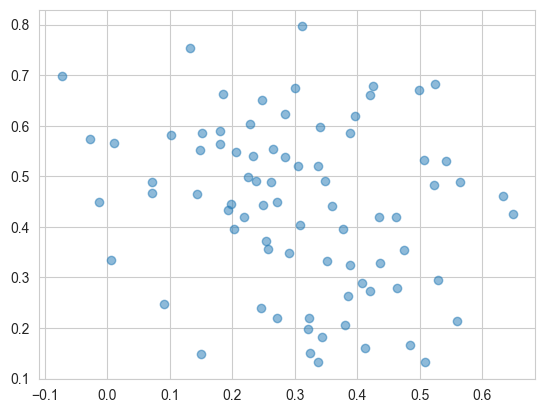

In [ ]:
from src.models.CryinGAN import CCCGDiscriminator, CCCGeneratorWithDiffusion, CCCGenerator

sample_x = dataset[0:32][0].cpu()
sample_y = dataset[0:32][1].cpu()

sample_x_mps = sample_x.to("mps")
sample_y_mps = sample_y.to("mps")

print(sample_x.shape, sample_y.shape)


test_frac = 0.2

dataset = dataset.to(run_params["training"]["device"])
trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])
print(len(trainset), len(testset))

out_samples = dataset.samples[0].shape[1]
out_dimensions = 2 #dataset.samples[0].shape[2]

kernel_size = (1,1)
stride=1

generator = CCCGenerator(
    kernel_size=kernel_size,
    stride=stride,
    channels_coefficient=1,
    rand_features=513,# 513 for one paper, 64 for another,
    out_dimensions=out_dimensions,
    out_samples=out_samples,
    latent_dim=256, # 128 for the papers
    fix_r=0.0049,
    clip_output = False
    # (
    #     dataset.y.min(dim=0).values.min(dim=0).values,
    #     dataset.y.max(dim=0).values.max(dim=0).values
    # )
    ).to("mps")


input_channels = 3

discriminator = CCCGDiscriminator(
    input_channels=input_channels, # x,y,r
    in_samples=out_samples, 
    kernel_size=(1,1),
    channels_coefficient=3
    ).to("mps")

gan = GAN(
    dataset, 
    dataset,# No separate test set
    generator_model=generator,
    discriminator_model=discriminator,
    **run_params
    )

print(summary(gan.generator, input_data=sample_x, depth=2))
print(summary(gan.discriminator, input_data=sample_y_mps, depth=2))

_out = gan.generate(sample_x)[0]

plot_pointcloud(_out, plot_radius=False)
10_603_201

In [ ]:
gan.train_n_epochs(
    epochs=run_params["training"]["epochs"],
    batch_size=run_params["training"]["batch_size"],
    experiment_name="Square lattice, small sample",
    requirements_file = Path("../top-level-requirements.txt"),
)

generated = gan.generate(sample_x).cpu()

plt.scatter(generated[0][:,0], generated[0][:,1].cpu())
plt.title("Generated sample")

# run 'mlflow server --host 127.0.0.1 --port 8080' from the CLI to start the server

## Test the discriminator with random data

In [ ]:
# Test the discriminator with random data

# Generate random data
random_data = torch.rand_like(sample_y).to("mps")
random_data = torch.randn_like(sample_y).to("mps")
print(random_data.shape)

plot_pointcloud(random_data[0].cpu().numpy(), plot_radius=False)

# Test the discriminator

output = gan.discriminator(random_data)
print(output.shape)
print("Mean of discriminator output:", output.mean().item())
plt.title(f"Discriminator output: {output[0].item()}")
plt.show()